# 1) Multi Scale Regression(도로좌표화 방식+가우시안)

### 1.1) 강남구 도로 데이터(Secondary filtering)

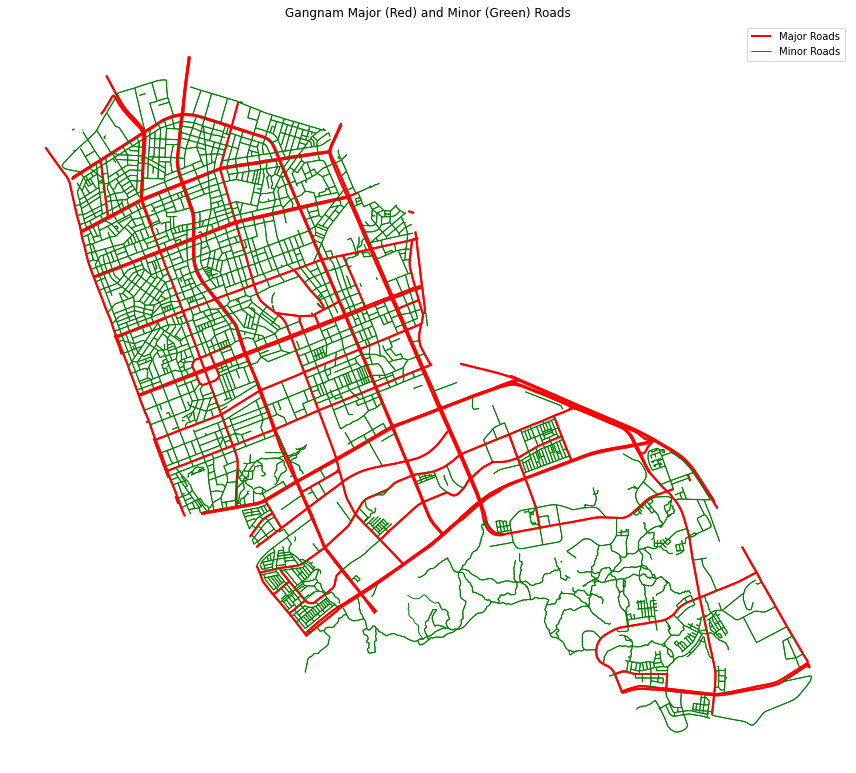

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
from shapely.strtree import STRtree
import matplotlib.pyplot as plt

#G = ox.graph_from_place("Gangnam-gu, Seoul, South Korea", network_type='drive') #차량이 다니는 차도
G_walk = ox.graph_from_place("Gangnam-gu, Seoul, South Korea", network_type='walk') #사람이 다니는 인도

# 그래프를 GeoDataFrame으로 변환
edges = ox.graph_to_gdfs(G_walk, nodes=False)

# highway 태그가 리스트일 수 있으므로 첫 항목으로 정규화
edges['highway_type'] = edges['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)

# secondary 이상 도로 등급 필터
major_highways = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary']
edges_major = edges[edges['highway_type'].isin(major_highways)]
minor_highways = ['path', 'pedestrian', 'residential', 'living_street']
edges_minor = edges[edges['highway_type'].isin(minor_highways)]

# 인덱스를 초기화해서 'u', 'v', 'key'를 열로 만들기
edges_major_reset = edges_major.reset_index()
edges_minor_reset = edges_minor.reset_index()

# 이제 key 튜플 추출 가능
major_edges_keys = list(edges_major_reset[['u', 'v', 'key']].itertuples(index=False, name=None))
minor_edges_keys = list(edges_minor_reset[['u', 'v', 'key']].itertuples(index=False, name=None))

# 주요 도로만 포함하는 서브그래프 생성
G_major = G_walk.edge_subgraph(major_edges_keys).copy()
G_minor = G_walk.edge_subgraph(minor_edges_keys).copy()

# 시각화
#fig, ax = ox.plot_graph(G_major, bgcolor='white', node_size=0, edge_color='red', edge_linewidth=1, show=True, close=False)
#fig, ax = ox.plot_graph(G_major, bgcolor='white', node_size=0, edge_color='blue', edge_linewidth=1, show=True, close=False)
fig, ax = plt.subplots(figsize=(12, 12))
edges_major.plot(ax=ax, color='red', linewidth=2, label='Major Roads')
edges_minor.plot(ax=ax, color='green', linewidth=1, label='Minor Roads')
ax.set_title('Gangnam Major (Red) and Minor (Green) Roads')
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()

### 1.2) 도로 좌표화(10m)

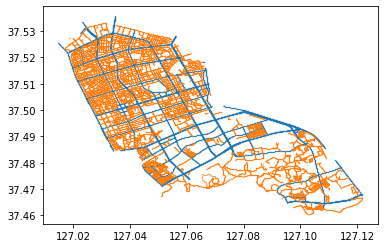

In [442]:
def densify_linestring(line, interval):
    num_segments = int(line.length // interval)
    return [line.interpolate(i * interval) for i in range(num_segments + 1)]

major_points = []
minor_points = []
for geom in edges_major.to_crs("EPSG:5179").geometry:
    major_points.extend(densify_linestring(geom, interval=10))
for geom in edges_minor.to_crs("EPSG:5179").geometry:
    minor_points.extend(densify_linestring(geom, interval=10))  
    
# 중복데이터 제거
major_points = gpd.GeoDataFrame(geometry=major_points, crs="EPSG:5179")
major_points_4326 = major_points.to_crs("EPSG:4326")
major_points_4326["lat"] = major_points_4326.geometry.y
major_points_4326["lon"] = major_points_4326.geometry.x
major_points_4326["coord_key"] = major_points_4326.geometry.apply(
    lambda g: f"{round(g.x, 6)}_{round(g.y, 6)}")
major_points_4326 = major_points_4326.drop_duplicates(subset=["coord_key"]).reset_index(drop=True)

minor_points = gpd.GeoDataFrame(geometry=minor_points, crs="EPSG:5179")
minor_points_4326 = minor_points.to_crs("EPSG:4326")
minor_points_4326["lat"] = minor_points_4326.geometry.y
minor_points_4326["lon"] = minor_points_4326.geometry.x
minor_points_4326["coord_key"] = minor_points_4326.geometry.apply(
    lambda g: f"{round(g.x, 6)}_{round(g.y, 6)}")
minor_points_4326 = minor_points_4326.drop_duplicates(subset=["coord_key"]).reset_index(drop=True)

plt.scatter(major_points_4326['lon'], major_points_4326['lat'], s=0.01)
plt.scatter(minor_points_4326['lon'], minor_points_4326['lat'], s=0.01)
plt.show()

### 1.3) 각 도로 포인트별 POI가중치 합

In [443]:
from scipy.spatial import cKDTree
from collections import defaultdict
from tqdm import tqdm

def gaussian_weight(distance, sigma):
    return np.exp(-(distance ** 2) / (2 * sigma ** 2))

def compute_gaussian_weights_by_category(all_points_gdf, poi_gdf, radius, sigma, category_column='category'):
    # 좌표계 변환 (EPSG:5179 기준)
    all_points_proj = all_points_gdf.to_crs("EPSG:5179")

    categories = poi_gdf[category_column].unique()
   
    # 결과를 GeoDataFrame으로 정리
    result_df = all_points_proj.copy()

    # 결과 저장 딕셔너리
    results_dict = defaultdict(list)

    for cat in tqdm(categories, desc="Processing Categories"):
        if cat=='지하철역':
            radius=5*radius
            sigma=5*sigma
        if cat=='관광명소':
            radius=3*radius
            sigma=3*sigma
        
        cat_poi = poi_gdf[poi_gdf[category_column] == cat].copy()
        cat_poi_proj = cat_poi.to_crs("EPSG:5179")

        # KDTree 생성
        poi_coords = np.vstack([cat_poi_proj.geometry.x, cat_poi_proj.geometry.y]).T
        if len(poi_coords) == 0:
            results_dict[cat] = [0] * len(all_points_proj)
            continue
        tree = cKDTree(poi_coords)

        # 각 포인트에 대해 가중치 총합 계산
        for point in all_points_proj.geometry:
            x, y = point.x, point.y
            indices = tree.query_ball_point([x, y], r=radius)

            if indices:
                nearby_pois = poi_coords[indices]
                distances = np.linalg.norm(nearby_pois - np.array([x, y]), axis=1)
                weight_sum = np.sum(gaussian_weight(distances, sigma))
            else:
                weight_sum = 0

            results_dict[cat].append(weight_sum)

    for cat in categories:
        result_df[f"{cat}_gaussian"] = results_dict[cat]

    return result_df.to_crs("EPSG:4326")  # 최종 반환은 WGS84 좌표계

# POI GeoDataFrame 준비
GangNam_POI = pd.read_csv("GangNam POI Data.csv").dropna(subset=['lat', 'lon'])
# 조건 1: 관광명소이면서 name에 '산', '숲', '릉'가 포함되지 않은 행 (제거 대상)
condition_delete = (GangNam_POI['category'] == '관광명소') & ~GangNam_POI['name'].str.contains('산|숲|릉', na=False)
GangNam_POI = GangNam_POI[~condition_delete].reset_index(drop=True)
GangNam_POI.loc[GangNam_POI['name'] == '서울도보관광코스 선릉~봉은사', 'lat'] = 37.508226
GangNam_POI.loc[GangNam_POI['name'] == '서울도보관광코스 선릉~봉은사', 'lon'] = 127.049192

GangNam_POI_gdf = gpd.GeoDataFrame(
    GangNam_POI,
    geometry=gpd.points_from_xy(GangNam_POI['lon'], GangNam_POI['lat']),
    crs='EPSG:4326')

# 거리 기반 가우시안 가중치 계산
major_POI_gaussian = compute_gaussian_weights_by_category(
    all_points_gdf=major_points_4326,  # 도로 위의 포인트
    poi_gdf=GangNam_POI_gdf,
    radius=300,
    sigma=40)

minor_POI_gaussian = compute_gaussian_weights_by_category(
    all_points_gdf=minor_points_4326,  # 도로 위의 포인트
    poi_gdf=GangNam_POI_gdf, 
    radius=300,
    sigma=40)

Processing Categories: 100%|██████████| 18/18 [00:57<00:00,  3.18s/it]


In [372]:
GangNam_POI = pd.read_csv("GangNam POI Data.csv").dropna(subset=['lat', 'lon'])
GangNam_POI[GangNam_POI['category']=='관광명소']


condition_category = GangNam_POI['category'] == '관광명소'
condition_name = GangNam_POI['name'].str.contains('산|숲|릉', na=False)
filtered_POI = GangNam_POI[condition_category & condition_name]
filtered_POI

# 조건 1: 관광명소이면서 name에 '산', '숲', '사'가 포함되지 않은 행 (제거 대상)
condition_delete = (GangNam_POI['category'] == '관광명소') & ~GangNam_POI['name'].str.contains('산|숲|릉', na=False)
GangNam_POI = GangNam_POI[~condition_delete].reset_index(drop=True)


GangNam_POI.loc[GangNam_POI['name'] == '서울도보관광코스 선릉~봉은사', 'lat'] = 37.508226
GangNam_POI.loc[GangNam_POI['name'] == '서울도보관광코스 선릉~봉은사', 'lon'] = 127.049192
GangNam_POI[GangNam_POI['name'] == '공원']

,index,grid_id,place_id,name,category,lat,lon


### 1.4) 각 도로 포인트별 단속건수 가중치 합

In [444]:
def compute_garbage_gaussian_weights(all_points_gdf, garbage_gdf, radius, sigma):
    all_points_proj = all_points_gdf.to_crs("EPSG:5179")
    garbage_proj = garbage_gdf.to_crs("EPSG:5179")

    garbage_coords = np.vstack([garbage_proj.geometry.x, garbage_proj.geometry.y]).T
    tree = cKDTree(garbage_coords)

    garbage_weights = []
    for point in all_points_proj.geometry:
        x, y = point.x, point.y
        indices = tree.query_ball_point([x, y], r=radius)
        if indices:
            distances = np.linalg.norm(garbage_coords[indices] - np.array([x, y]), axis=1)
            weight_sum = np.sum(gaussian_weight(distances, sigma))
        else:
            weight_sum = 0
        garbage_weights.append(weight_sum)

    all_points_gdf = all_points_gdf.copy()
    all_points_gdf['garbage_weight'] = garbage_weights
    return all_points_gdf.to_crs("EPSG:4326")

garbage_snapped = pd.read_csv("GangNam Garbage Count_snapped.csv")
garbage_gdf=gpd.GeoDataFrame(
    garbage_snapped,
    geometry=gpd.points_from_xy(garbage_snapped['snapped_lon'], garbage_snapped['snapped_lat']),
    crs='EPSG:4326')

# garbage_weight 계산
major_garbage_gaussian = compute_garbage_gaussian_weights(
    all_points_gdf=major_points_4326,
    garbage_gdf=garbage_gdf,
    radius=400,
    sigma=200)

minor_garbage_gaussian = compute_garbage_gaussian_weights(
    all_points_gdf=minor_points_4326,
    garbage_gdf=garbage_gdf,
    radius=400,
    sigma=200)

### 1.5) 각 도로 포인트별 쓰레기통 가중치 합

In [445]:
def compute_trashcan_gaussian_weights(all_points_gdf, trashcan_gdf, radius=150, sigma=75):
    all_points_proj = all_points_gdf.to_crs("EPSG:5179")
    trashcan_proj = trashcan_gdf.to_crs("EPSG:5179")

    trashcan_coords = np.vstack([trashcan_proj.geometry.x, trashcan_proj.geometry.y]).T
    tree = cKDTree(trashcan_coords)

    trashcan_weights = []
    for point in all_points_proj.geometry:
        x, y = point.x, point.y
        indices = tree.query_ball_point([x, y], r=radius)
        if indices:
            distances = np.linalg.norm(trashcan_coords[indices] - np.array([x, y]), axis=1)
            weight_sum = np.sum(gaussian_weight(distances, sigma))
        else:
            weight_sum = 0
        trashcan_weights.append(weight_sum)

    all_points_gdf = all_points_gdf.copy()
    all_points_gdf['trashcan_gaussian'] = trashcan_weights
    return all_points_gdf.to_crs("EPSG:4326")


trashcan_snapped = pd.read_csv("GangNam Trashcan_snapped.csv")
trashcan_gdf=gpd.GeoDataFrame(
    trashcan_snapped,
    geometry=gpd.points_from_xy(trashcan_snapped['snapped_lon'], trashcan_snapped['snapped_lat']),
    crs='EPSG:4326')

# garbage_weight 계산
major_trashcan_gaussian = compute_trashcan_gaussian_weights(
    all_points_gdf=major_points_4326,
    trashcan_gdf=trashcan_gdf,
    radius=200,
    sigma=50)
minor_trashcan_gaussian = compute_trashcan_gaussian_weights(
    all_points_gdf=minor_points_4326,
    trashcan_gdf=trashcan_gdf,
    radius=200,
    sigma=50)
# 쓰레기통 주변의 무단투기 경향을 살펴보려면 sigma를 매우 줄이고, 반대로 쓰레기통과 거리가 떨어진 곳에서 감소효과를 보려면 sigma를 늘린다

### 1.6) 유동인구 데이터 불러오기

In [446]:
footprint=pd.read_csv("2016_GangNam_with_latlon.csv")[['geometry','lat', 'lon', 'foot_count']]
footprint_gdf=gpd.GeoDataFrame(
    footprint,
    geometry=gpd.points_from_xy(footprint['lon'], footprint['lat']),
    crs='EPSG:4326')

footprint_gdf=footprint_gdf.to_crs('EPSG:5179')
footprint_gdf['grid_x'] = (footprint_gdf.geometry.x // 100).astype(int)
footprint_gdf['grid_y'] = (footprint_gdf.geometry.y // 100).astype(int)

# EPSG:5179로 변환
major_points_proj = major_points_4326.to_crs("EPSG:5179")
major_points_proj['grid_x'] = (major_points_proj.geometry.x // 100).astype(int)
major_points_proj['grid_y'] = (major_points_proj.geometry.y // 100).astype(int)
major_footprints = major_points_proj.merge(footprint_gdf[['grid_x', 'grid_y','foot_count']], on=['grid_x', 'grid_y'])
major_footprints = major_footprints.to_crs("EPSG:4326")

minor_points_proj = minor_points_4326.to_crs("EPSG:5179")
minor_points_proj['grid_x'] = (minor_points_proj.geometry.x // 100).astype(int)
minor_points_proj['grid_y'] = (minor_points_proj.geometry.y // 100).astype(int)
minor_footprints = minor_points_proj.merge(footprint_gdf[['grid_x', 'grid_y','foot_count']], on=['grid_x', 'grid_y'])
minor_footprints = minor_footprints.to_crs("EPSG:4326")

### 1.7) 데이터 통합

In [447]:
selected_cols=['대형마트_gaussian', '편의점_gaussian', '어린이집, 유치원_gaussian', '학교_gaussian', '학원_gaussian',
       '주차장_gaussian', '주유소, 충전소_gaussian', '지하철역_gaussian', '은행_gaussian', '문화시설_gaussian',
       '중개업소_gaussian', '공공기관_gaussian', '관광명소_gaussian', '숙박_gaussian', '음식점_gaussian',
       '카페_gaussian', '병원_gaussian', '약국_gaussian']

major_merged = pd.merge(
    major_footprints,
    major_garbage_gaussian[['coord_key', 'garbage_weight']],
    on='coord_key')
major_merged =  pd.merge(
    major_merged,
    major_trashcan_gaussian[['coord_key', 'trashcan_gaussian']],
    on='coord_key',
    how='left')
major_merged = pd.merge(
    major_merged,
    major_POI_gaussian[np.append(['coord_key'], selected_cols)],
    on='coord_key',
    how='left')

minor_merged = pd.merge(
    minor_footprints,
    minor_garbage_gaussian[['coord_key', 'garbage_weight']],
    on='coord_key')
minor_merged =  pd.merge(
    minor_merged,
    minor_trashcan_gaussian[['coord_key', 'trashcan_gaussian']],
    on='coord_key',
    how='left')
minor_merged = pd.merge(
    minor_merged,
    minor_POI_gaussian[np.append(['coord_key'], selected_cols)],
    on='coord_key',
    how='left')

### 1.8) 상호작용항 생성

In [448]:
for cat in [col for col in major_merged.columns if col.endswith('_gaussian')]:
    inter_col = f'inter_{cat.replace("_gaussian", "")}'
    major_merged[inter_col] = major_merged[cat] * major_merged['foot_count']# / (1+0.05*major_merged['trashcan_weight'])

for cat in [col for col in minor_merged.columns if '_gaussian' in col]:
    inter_col = f'inter_{cat.replace("_gaussian", "")}'
    minor_merged[inter_col] = minor_merged[cat] * minor_merged['foot_count']# / (1+0.1*minor_merged['trashcan_weight'])

### 1.9) 상위업종으로 통합

In [449]:
major_merged['inter_의료업종']=(major_merged['inter_병원']+6*major_merged['inter_약국'])/7
major_merged['inter_교육시설']=major_merged['inter_어린이집, 유치원']+major_merged['inter_학교']
major_merged['inter_식음료업종']=(4*major_merged['inter_카페']+major_merged['inter_음식점']+20*major_merged['inter_편의점'])/25


minor_merged['inter_의료업종']=(minor_merged['inter_병원']+6*minor_merged['inter_약국'])
minor_merged['inter_교육시설']=minor_merged['inter_어린이집, 유치원']+minor_merged['inter_학교']
minor_merged['inter_식음료업종']=(4*minor_merged['inter_카페']+minor_merged['inter_음식점']+20*minor_merged['inter_편의점'])/25

In [81]:
categories = GangNam_POI['category'].unique()

for cat in tqdm(categories, desc="Processing Categories"):
    cat_poi = GangNam_POI[GangNam_POI['category'] == cat].copy()
    print(f"{cat} : {len(cat_poi)}")
#GangNam_POI[GangNam_POI['category'] == '중개업소']

Processing Categories: 100%|██████████| 18/18 [00:00<00:00, 540.00it/s]

주차장 : 1499
카페 : 3209
학원 : 4008
음식점 : 10974
관광명소 : 46
은행 : 960
문화시설 : 301
병원 : 3090
약국 : 510
숙박 : 209
지하철역 : 38
편의점 : 764
주유소, 충전소 : 35
중개업소 : 2644
대형마트 : 47
학교 : 84
공공기관 : 63
어린이집, 유치원 : 201


# 2) Regrassion

                            OLS Regression Results                            
Dep. Variable:         garbage_weight   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     3286.
Date:                Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:16:27   Log-Likelihood:            -1.7956e+05
No. Observations:               23032   AIC:                         3.591e+05
Df Residuals:                   23023   BIC:                         3.592e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            231.3318      6.429     35.

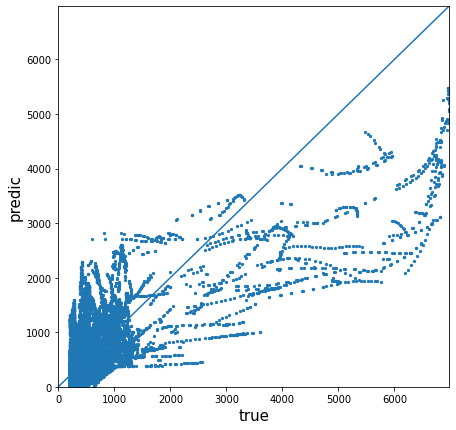

In [450]:
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
'''
selected_cols=['inter_대형마트', 'inter_편의점', 'inter_어린이집, 유치원', 'inter_학교', 'inter_학원',
       'inter_주차장', 'inter_주유소, 충전소', 'inter_지하철역', 'inter_은행', 'inter_문화시설',
       'inter_중개업소', 'inter_공공기관', 'inter_관광명소', 'inter_숙박', 'inter_음식점',
       'inter_카페', 'inter_병원', 'inter_약국']
'''
selected_cols=['inter_식음료업종', 'inter_문화시설', 'inter_지하철역', 'inter_교육시설', 'inter_공공기관', 'inter_trashcan']
major_filtered=major_merged[(major_merged['garbage_weight']>200)]
minor_filtered=minor_merged[(minor_merged['garbage_weight']>200)]

majmin_filtered = pd.concat([major_filtered, minor_filtered], ignore_index=True)

X = sm.add_constant(majmin_filtered[['inter_식음료업종', 'inter_교육시설', 'inter_지하철역', 'inter_관광명소','inter_문화시설', 'inter_공공기관','inter_약국', 'inter_trashcan']])
#X = sm.add_constant(minor_filtered[selected_cols])
y = majmin_filtered['garbage_weight'].fillna(0)

#model = RLM(y, sm.add_constant(X)).fit() #Robust Regression
model = sm.OLS(y, X).fit()
print(model.summary())

manual_coefs = model.params.values#summary_by_category['coef 가중평균'].values/11.5
y_true = majmin_filtered['garbage_weight'].fillna(0)
#manual_coefs[3]=0.04
#manual_coefs[-2]=0.005
y_pred = X @ manual_coefs  # 행렬 곱

plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, s=5)
plt.plot([0,max(np.append(y_true, y_pred))], [0,max(np.append(y_true, y_pred))])
plt.xlim(0,max(np.append(y_true, y_pred)))
plt.ylim(0 ,max(np.append(y_true, y_pred)))
#plt.xlim(0,1000)
#plt.ylim(0 ,1000)
plt.xlabel('true', size=15)
plt.ylabel('predic', size= 15)
plt.show()

In [452]:
y_true[(y_true>1000)&(y_pred<300)]
#majmin_filtered.loc[427] #강남구청
#majmin_filtered.loc[3477]
#majmin_filtered.loc[150] #압구정역
#majmin_filtered.loc[10422]
#majmin_filtered.loc[10168]
#majmin_filtered.loc[9250] #빌라
#majmin_filtered.loc[117] #공원
majmin_filtered.loc[4001]
manual_coefs

array([ 2.31331840e+02,  1.48325408e-02,  7.27821629e-03,  1.29233057e-03,
       -1.11474019e-01, -1.03648033e-02, -8.07157615e-02,  2.56815074e-02,
       -8.59585587e-03])

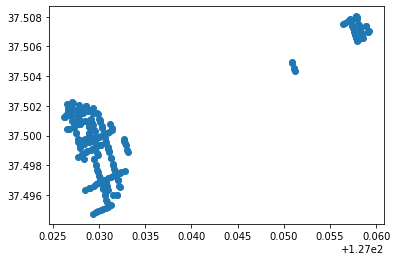

0.2458615067738164

In [401]:
plt.scatter(minor_filtered['lon'], minor_filtered['lat'])
plt.show()
len(minor_filtered)/len(minor_merged[minor_merged['garbage_weight']>1])
sum(minor_filtered['garbage_weight'][:])/sum(minor_merged[minor_merged['garbage_weight']>10]['garbage_weight'])

In [433]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
print(vif)

const             2.765657
inter_식음료업종       4.352520
inter_교육시설        2.333270
inter_지하철역        2.501765
inter_관광명소        1.824659
inter_문화시설        1.313270
inter_공공기관        1.695647
inter_약국          2.371828
inter_trashcan    2.370076
dtype: float64


In [454]:
majmin_filtered
majmin_merged = pd.concat([major_merged, minor_merged], ignore_index=True)
XX = sm.add_constant(majmin_merged[['inter_식음료업종', 'inter_교육시설', 'inter_지하철역', 'inter_관광명소','inter_문화시설', 'inter_공공기관','inter_약국', 'inter_trashcan']])
YY=XX @ manual_coefs
heatmap=majmin_merged[['lat', 'lon']]
heatmap['prediction']=YY
heatmap.to_csv('GangNam_garbage_pred_10m.csv', index=False, encoding='utf-8-sig')  # 한글 깨짐 방지

0         556.632968
1         555.123639
2         552.014929
3         547.513018
4         556.707017
            ...     
95309     243.617670
95310     243.553752
95311     243.529322
95312     243.603787
95313    1625.033568
Length: 95314, dtype: float64